In [7]:
pip install pandas numpy datasets tensorflow scikit-learn fastapi uvicorn matplotlib


In [8]:
!pip install datasets



Epoch 1/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0328 - val_loss: 0.0049
Epoch 2/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 4/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0011 - val_loss: 8.8427e-04
Epoch 5/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 8.3057e-04 - val_loss: 7.6361e-04
Epoch 6/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 7.4787e-04 - val_loss: 7.0972e-04
Epoch 7/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.6788e-04 - val_loss: 6.3863e-04
Epoch 8/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.1353e-04 - val_loss: 5.9687e-04
Epoch 9/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6.0350e-04 - val_loss: 5.7378e-04
Epoch 10/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 5.6486e-04 - val_loss: 5.3666e-04
Epoch 11/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - los

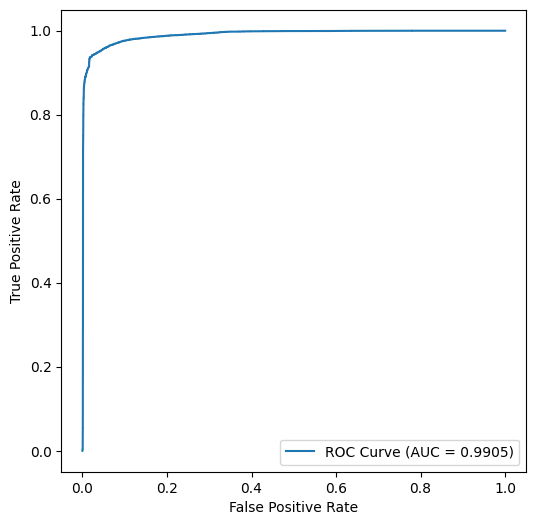

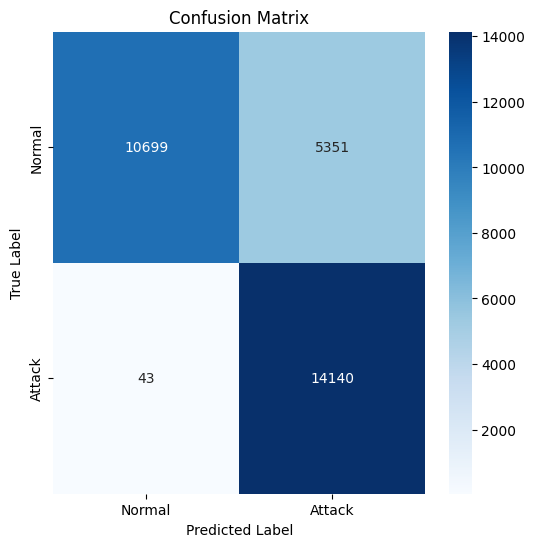

Accuracy: 0.8216
Precision: 0.7255
Recall: 0.9970
F1 Score: 0.8398
ROC AUC: 0.9905


In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Attention
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# -----------------------------
# 1️⃣ Load & Preprocess NSL-KDD Dataset
# -----------------------------

# Load dataset
ds = load_dataset("Mireu-Lab/NSL-KDD")
df = pd.DataFrame(ds["train"])

# Map 'class' to binary labels (Normal = 0, Attack = 1)
df["class"] = df["class"].apply(lambda x: 0 if x == "normal" else 1)

# One-hot encoding categorical features
categorical_features = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[categorical_features]).toarray()

# Convert to DataFrame and concatenate with the original
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)

# Extract features and labels
X = df.drop(columns=['class']).values  # Features
y = df['class'].values  # Labels

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select only normal traffic for training (Self-Supervised Learning)
X_train_normal = X_train[y_train == 0]

# -----------------------------
# 2️⃣ Autoencoder with Attention Mechanism
# -----------------------------

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        q, k, v = inputs, inputs, inputs  # Query, Key, Value are same (Self-Attention)
        attention_scores = tf.matmul(q, k, transpose_b=True)  # Compute attention scores
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)  # Apply softmax
        attention_output = tf.matmul(attention_scores, v)  # Multiply scores with values
        return attention_output

# Define Autoencoder Model
input_dim = X_train_normal.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(inputs)
encoded = Dense(32, activation='relu')(encoded)
attention_output = AttentionLayer()(encoded)  # Apply Attention Mechanism
encoded = Dense(16, activation='relu')(attention_output)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
outputs = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, validation_split=0.1)

# -----------------------------
# 3️⃣ Compute Reconstruction Loss & Set Threshold
# -----------------------------
reconstruction = autoencoder.predict(X_train_normal)
train_loss = np.mean(np.square(X_train_normal - reconstruction), axis=1)
threshold = np.percentile(train_loss, 65)  # 95th percentile as threshold

# -----------------------------
# 4️⃣ Evaluate Model Performance
# -----------------------------
def evaluate_model(autoencoder, X_test, y_test):
    reconstructions = autoencoder.predict(X_test)
    test_loss = np.mean(np.square(X_test - reconstructions), axis=1)

    y_pred = (test_loss > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, test_loss)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, test_loss)

    # Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(roc_auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Plot Confusion Matrix as Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

# Run evaluation
evaluate_model(autoencoder, X_test, y_test)

